In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import glob
import os

%run ./utils.ipynb
%run ./LSTM-AE.ipynb

- Selection of lead MLII from the MIT-BIH arrythmia datbase
- Segmentation of the signls into 360 datapoints (180 points each side of the R peak) centered around the R peak
- normalisation of the heartbeats between -1 and 1
- denoising of the signals
- selection of labels and grouping them according to AAMI standars in 5 classes: Normal beat (N), Supraventricular ectopic beat (SVEB), Ventricular Ectopic Beat (VEB), Fusion beat (F), unnoun beat (Q)

In [2]:
'''Download the database from: https://physionet.org/content/mitdb/1.0.0/'''
paths = glob.glob('C:/Users/1938759.IKB/OneDrive - Brunel University London/05 Datasets/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/*.atr')             
paths.pop(1)

[leadML2, _, labels] = segmentation(paths)

# Normalise signals between [-1 and 1]
leadML2 = normalise(leadML2, -1, 1)

# Filter the signals
leadML2 = Savitzky_Golay(leadML2, fs=360)

# Exclude the signals that have the annotations in exclude_char 
[labels,Normal, AA, LBBB, RBBB] = exclude(labels,leadML2)

In [3]:
print(len(Normal), len(AA), len(LBBB), len(RBBB))

63694 2493 8070 5724


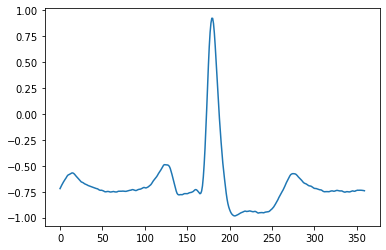

In [26]:
plt.plot(Normal[1000])

- Split the dataset into training, validation and testing sets
- transforme data into tensors
- use dataloders to prep data for training 

In [4]:
from sklearn.model_selection import train_test_split
# set aside 20% of train and test data for evaluation

# In the line below: Data = pd.DataFrame(x) change the "x" with the name of the desired class for feature extraction 
Data = pd.DataFrame(AA)

X_train, X_test = train_test_split(Data, test_size=0.2, shuffle = True, random_state = 8)
X_test, X_val = train_test_split(X_test, test_size=0.5, shuffle = True, random_state= 8) 

from torch.utils.data import DataLoader
batch_size = 1

X_train = X_train.astype(np.float32).to_numpy().tolist()
X_val = X_val.astype(np.float32).to_numpy().tolist()
X_test = X_test.astype(np.float32).to_numpy().tolist()

training_tensors =[torch.tensor(s).unsqueeze(1) for s in X_train]
validation_tensors =[torch.tensor(s).unsqueeze(1) for s in X_val]
test_tensors=[torch.tensor(s).unsqueeze(1) for s in X_test]

n_seq, seq_len, n_features = torch.stack(training_tensors).shape

trainloader = DataLoader(dataset=training_tensors,batch_size=batch_size,shuffle=True, drop_last=True)
valloader = DataLoader(dataset=validation_tensors,batch_size=batch_size,shuffle=True, drop_last=True)
testloader = DataLoader(dataset=test_tensors,batch_size=batch_size,shuffle=True, drop_last=True)

In [ ]:
i = next(iter(testloader))
print(i.shape)

# Traing LSTM for FE for Normal class

In [ ]:
%run ./LSTM-AE.ipynb
import time

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(segmented_ecg, labels_enc, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

# training_dataset =[([X_train[i], y_train[i]]) for i in range(len(y_train))]
# test_dataset =[([X_test[i], y_test[i]]) for i in range(len(y_test))]
# validation_dataset =[([X_val[i], y_val[i]]) for i in range(len(y_val))]

#####################
X_train = np.array(X_train).astype(np.float32).tolist()
X_val = np.array(X_val).astype(np.float32).tolist()
X_test = np.array(X_test).astype(np.float32).tolist()

training_tensors =[torch.tensor(s).unsqueeze(0) for s in X_train]
validation_tensors =[torch.tensor(s).unsqueeze(0) for s in X_val]
test_tensors=[torch.tensor(s).unsqueeze(0) for s in X_test]

# training_labels = [torch.tensor(s).unsqueeze(0) for s in y_test]
# validation_labels = [torch.tensor(s).unsqueeze(0) for s in y_val]
# test_labels = [torch.tensor(s).unsqueeze(0) for s in y_test]

training_dataset =[([training_tensors[i], training_labels[i]]) for i in range(len(training_labels))]
validation_dataset =[([validation_tensors[i], validation_labels[i]]) for i in range(len(validation_tensors))]
test_dataset=[([test_tensors[i], test_labels[i]]) for i in range(len(test_labels))]

https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
    
net = SimpleNeuralNet(28*28,100,10)
optimizer = optim.SGD(net.parameters(),lr=1e-1)
criterion = F.nll_loss
And after this we can call this function to find our learning rate and plot the results.

logs,losses = find_lr()
plt.plot(logs[10:-5],losses[10:-5])


In [ ]:
# RAE it's a class that connects the Encoder and Decoder toghether, preparing it for the training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

embedding_dim = 64
n_epochs = 150

model = RAE(seq_len, n_features, embedding_dim, batch_size)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.MSELoss(reduction='mean').to(device)   # nn.L1Loss sum

model, history = train_model(model,trainloader, valloader, n_epochs, optimizer, criterion)

**Visualise the results**

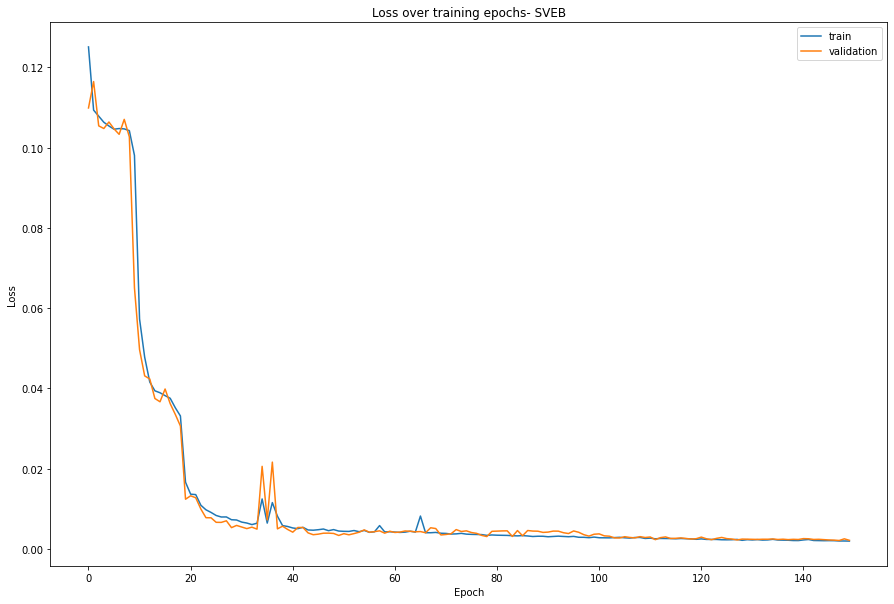

In [7]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=[15,10]).gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'])
plt.title('Loss over training epochs- SVEB')
plt.show()

# Save the LSTM autoencoder

In [8]:
import os 
PATH = 'Z:/1938759/EHRA- abstract/LSTM-AE feature extraction/models'
torch.save(model.state_dict(), os.path.join(PATH,'LBBB_LSTMautoencoder.pth'))

# Save the Encoder and Decoder separately 

In [9]:
# 1) Save the parameters of the encoder 
PATH = 'Z:/1938759/EHRA- abstract/LSTM-AE feature extraction/models'
torch.save(model.encoder.state_dict(), os.path.join(PATH,'LBBB_encoder.pth'))
# 2) Save the parameters of the decoder 
torch.save(model.decoder.state_dict(), os.path.join(PATH,'LBBB_decoder.pth'))

# Test the model 

In [10]:
predictions, losses = [], []
#criterion = nn.L1Loss(reduction='sum').to(device)
model = model.eval()
criterion = nn.MSELoss(reduction='mean').to(device)   # nn.L1Loss sum

with torch.no_grad():
    for batch_idx, (data) in enumerate (test_tensors):
        data = data.to(device)
        batch_size = data.shape[0]
        data_pred = model(data)
        loss = criterion(data_pred, data)     

        predictions.append(data_pred.cpu().numpy())  #.flatten()
        losses.append(loss.item())

In [ ]:
predictions, pred_losses = predict(model, testloader)  #loaded_model

In [ ]:
plt.plot(predictions[0])

In [11]:
test =[]
for data in test_tensors:
    test.append(data.cpu().numpy())

In [ ]:
plt.plot(predictions[4])

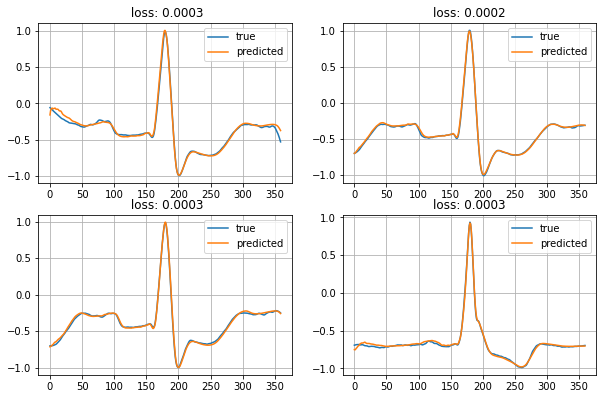

In [12]:
# adding first subplot
#plt.figure(figsize=(20,10))
plt.figure(figsize=[10,10])
plt.subplot(321)
plt.plot(test[9], label = 'true')
plt.plot(predictions[9], label = 'predicted')
plt.title(f' loss: {np.around(losses[4],4)}')
plt.legend()
plt.grid()

# adding second subplot
plt.subplot(322)
plt.plot(test[25], label = 'true')
plt.plot(predictions[25], label = 'predicted')
plt.title(f'loss: {np.around(losses[25],4)}')
plt.legend()
plt.grid()
#adding second subplot
plt.subplot(323)
plt.plot(test[14], label = 'true')
plt.plot(predictions[14], label = 'predicted')
plt.title(f' loss: {np.around(losses[14],4)}')
plt.legend()
plt.grid()

# adding second subplot
plt.subplot(324)
plt.plot(test[35], label = 'true')
plt.plot(predictions[35], label = 'predicted')
plt.title(f'loss: {np.around(losses[20],4)}')
plt.grid()
plt.legend()

# Load model

In [5]:
# Extract the hidden features/ encoded signals from the encoder

# 1) Load the encoder
embedding_dim = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
encoder_PATH = r'C:/Users/1938759.IKB/OneDrive - Brunel University London/Projects with Alex/EHRA- abstract/LSTM-AE feature extraction/models/encoder_Normal.pth'
encoder_model = Encoder(seq_len, n_features, batch_size, embedding_dim = 64).to(device) # load the encoder to cuda
encoder_model.load_state_dict(torch.load(encoder_PATH))
encoder_model.eval()


hidden_features, HF_list = [] , []
criterion = nn.MSELoss(reduction='mean').to(device)   # nn.L1Loss sum
with torch.no_grad():
    for batch_idx, (data) in enumerate (testloader):
        data = data.to(device)
        data_pred = encoder_model(data.float())
        
        HF_list.append(data_pred.cpu().numpy())
        hidden_features.append(data_pred)  #.flatten()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/1938759.IKB/OneDrive - Brunel University London/Projects with Alex/EHRA- abstract/LSTM-AE feature extraction/models/encoder_Normal.pth'

In [ ]:
# 1) Load the decoder
decoder_PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\LSTM-AE feature extraction\models\decoder_Normal.pth'

decoder_model = Decoder(seq_len, embedding_dim, batch_size, n_features).to(device)
decoder_model.load_state_dict(torch.load(decoder_PATH))
decoder_model.eval()


decoded_features, decodedF_list = [], []
with torch.no_grad():
    for batch_idx, (data) in enumerate (hidden_features):
        data = data.to(device)
        batch_size = data.shape[0]
        data_pred = decoder_model(data)
        
        decodedF_list.append(data_pred.cpu().numpy())  
        decoded_features.append(data_pred)  


In [5]:
from sklearn.model_selection import train_test_split
# set aside 20% of train and test data for evaluation

# In the line below: Data = pd.DataFrame(x) change the "x" with the name of the desired class for feature extraction 
Data = pd.DataFrame(LBBB)

X_train, X_test = train_test_split(Data, test_size=0.2, shuffle = True, random_state = 8)
X_test, X_val = train_test_split(X_test, test_size=0.5, shuffle = True, random_state= 8) 

from torch.utils.data import DataLoader
batch_size = 1

X_train = X_train.astype(np.float32).to_numpy().tolist()
X_val = X_val.astype(np.float32).to_numpy().tolist()
X_test = X_test.astype(np.float32).to_numpy().tolist()

training_tensors =[torch.tensor(s).unsqueeze(1) for s in X_train]
validation_tensors =[torch.tensor(s).unsqueeze(1) for s in X_val]
test_tensors=[torch.tensor(s).unsqueeze(1) for s in X_test]

n_seq, seq_len, n_features = torch.stack(training_tensors).shape

# trainloader = DataLoader(dataset=training_tensors,batch_size=batch_size,shuffle=True, drop_last=True)
# valloader = DataLoader(dataset=validation_tensors,batch_size=batch_size,shuffle=True, drop_last=True)
# testloader = DataLoader(dataset=test_tensors,batch_size=batch_size,shuffle=True, drop_last=True)

In [ ]:
training_tensors[0].shape

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RAE(seq_len,n_features,embedding_dim = 32)
model = model.to(device)

model, history = train_model(model,training_tensors, validation_tensors, n_epochs = 150)

Epoch 1: train loss 0.12510518573081442 val loss 0.1098859811794876
Epoch 2: train loss 0.1093524027352661 val loss 0.1164684277835684
Epoch 3: train loss 0.10783904615635008 val loss 0.10542366731694935
Epoch 4: train loss 0.10632937315382904 val loss 0.10476678853584488
Epoch 5: train loss 0.10539427959813726 val loss 0.10639001109638474
Epoch 6: train loss 0.10459279161018159 val loss 0.10467908517117099
Epoch 7: train loss 0.10475688636166769 val loss 0.1033144385462726
Epoch 8: train loss 0.10467275753363395 val loss 0.10704484557481356
Epoch 9: train loss 0.1042329756453024 val loss 0.10267948661613494
Epoch 10: train loss 0.09806906867684632 val loss 0.06504310980956203
Epoch 11: train loss 0.05726567453661786 val loss 0.04963407576975067
Epoch 12: train loss 0.04777332015090035 val loss 0.04311499108451902
Epoch 13: train loss 0.04157422290986682 val loss 0.042339111574148804
Epoch 14: train loss 0.039389414535531006 val loss 0.037472910526014695
Epoch 15: train loss 0.03890392

Epoch 115: train loss 0.002561160702317007 val loss 0.0025824623828434442
Epoch 116: train loss 0.0025049197066654557 val loss 0.002624764966632325
Epoch 117: train loss 0.0025759905364519803 val loss 0.0027228296093928053
Epoch 118: train loss 0.002523870729049628 val loss 0.0025967667076026656
Epoch 119: train loss 0.0024717157124374903 val loss 0.002444999363882002
Epoch 120: train loss 0.0023768660973970753 val loss 0.002530323886004556
Epoch 121: train loss 0.0024784314452890757 val loss 0.002920670171058823
Epoch 122: train loss 0.002346578794810391 val loss 0.0025116465405050793
Epoch 123: train loss 0.0023467643352266553 val loss 0.0022836790238964385
Epoch 124: train loss 0.002339915316237579 val loss 0.0026162164868576893
Epoch 125: train loss 0.0022592426333006084 val loss 0.002839808284653128
Epoch 126: train loss 0.002250455838416263 val loss 0.0025414106435767236
Epoch 127: train loss 0.002271214660554297 val loss 0.002448737881799278
Epoch 128: train loss 0.0023506015303